# Business Context

This case requires trainees to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns.

Candidates can use whatever method they wish to develop their machine learning model. Following usual model development procedures, the model would be estimated on the calibration data and tested on the validation data. This case requires both statistical analysis and creativity/judgment. We recommend you spend time on both fine-tuning and interpreting the results of your machine learning model.

Your task is to execute the process for proactive detection of fraud while answering following questions.
1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

**Data Dictionary**
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

3. amount - amount of the transaction in local currency

4. nameOrig - customer who started the transaction

5. oldbalanceOrg - initial balance before the transaction

6. newbalanceOrig - new balance after the transaction

7. nameDest - customer who is the recipient of the transaction

8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from collections import Counter
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

# Set a global seed value
seed_value=12321

## Preliminary Analysis (Feature Cleaning, Visualization and Basic Transformations

In [ ]:
def prelim_clean(path):
  df = pd.read_csv(path) # Read the data. Change the command to read HDF5 files for large datasets
  df = df.drop_duplicates() # Drop duplicate data, if any
  df = df.loc[~df.index.duplicated(), :] # Drop duplicate indexes, if any
  df.columns = df.columns.str.replace(" ", "") # Remove in-between and trailing spaces between column names
  return df

def prelim_inspection(df):
  display(df.head()) # look at data
  display(df.shape)  # look a shape of data
  display(df.iloc[:5, :5].dtypes)  # look at data types. Ideally look at all rows. Only look at first five here for minimal output
  display(df.isna().any())
  display(df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

In [ ]:
data = prelim_clean("../input/fraudulent-transactions-data/Fraud.csv")

In [ ]:
prelim_inspection(data)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


(6362620, 11)

step               int64
type              object
amount           float64
nameOrig          object
oldbalanceOrg    float64
dtype: object

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
85%,3.780000e+02,2.949193e+05,4.014821e+05,4.463039e+05,1.902566e+06,2.133562e+06,0.000000e+00,0.000000e+00
95%,4.900000e+02,5.186342e+05,5.823702e+06,5.980262e+06,5.147230e+06,5.515716e+06,0.000000e+00,0.000000e+00
99%,6.810000e+02,1.615979e+06,1.602726e+07,1.617616e+07,1.237182e+07,1.313787e+07,0.000000e+00,0.000000e+00


In [ ]:
# Shape the data
data.shape

(6362620, 11)

In [ ]:
# Get head of the data
data.head(200)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
195,1,CASH_OUT,210370.09,C2121995675,0.0,0.00,C1170794006,1442298.03,22190.99,0,0
196,1,CASH_OUT,36437.06,C2120063568,0.0,0.00,C1740000325,154606.00,1363368.51,0,0
197,1,CASH_OUT,82691.56,C1620409359,0.0,0.00,C248609774,657983.89,6453430.91,0,0
198,1,CASH_OUT,338767.10,C691691381,0.0,0.00,C453211571,544481.28,3461666.05,0,0


In [ ]:
data.tail(200)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362420,727,TRANSFER,124582.58,C651444933,124582.58,0.0,C1161818914,0.00,0.00,1,0
6362421,727,CASH_OUT,124582.58,C1098290230,124582.58,0.0,C1739564153,320485.06,445067.64,1,0
6362422,727,TRANSFER,263401.81,C806437930,263401.81,0.0,C1469754483,0.00,0.00,1,0
6362423,727,CASH_OUT,263401.81,C850961884,263401.81,0.0,C1203132980,251586.80,514988.60,1,0
6362424,727,TRANSFER,69039.64,C922622756,69039.64,0.0,C417851521,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [ ]:
df_copy = data.copy(deep=True)
df_copy[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]] = np.round(df_copy[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]], 0).astype("int64")

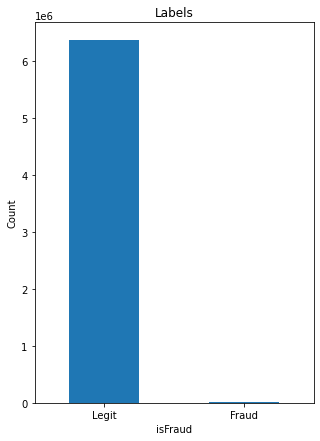

In [ ]:
# Distribution of labels
plt.figure(figsize=(5, 7))
labels = ["Legit", "Fraud"]
count_classes = data.value_counts(data["isFraud"], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [ ]:
notFraud = len(df_copy[df_copy["isFraud"] == 0])
fraud = len(df_copy[df_copy["isFraud"] == 1])
notFraud_percent = (notFraud / (notFraud + fraud)) * 100
fraud_percent = (fraud / (notFraud + fraud)) * 100

print("Number of legitimate transactions: ", notFraud)
print("Number of illegitimate transactions: ", fraud)
print("Percentage of legitimate transactions: {:.2f} %".format(notFraud_percent))
print("Percentage of illegitimate transactions: {:.2f} %".format(fraud_percent))

Number of legitimate transactions:  6354407
Number of illegitimate transactions:  8213
Percentage of legitimate transactions: 99.87 %
Percentage of illegitimate transactions: 0.13 %


Highly unbalanced data as percentage of legit transactions=99.87% and Percentage of Fraud transactions=0.13%

**Observations and Analysis**
- Apply sampling techniques (oversampling and/or undersampling) for enhancing the proportion of minority labels

In [ ]:
# Undersampling
minority_data = df_copy[df_copy["isFraud"]==1]
minority_data_test = minority_data.sample(frac=0.1, replace=False)
minority_data = minority_data.drop(index=minority_data_test.index, axis=0)
majority_data = df_copy.drop(index=df_copy.loc[df_copy.loc[:, "isFraud"]==1, : ].index).sample(frac=0.002, replace=False)
majority_data_test = majority_data.sample(frac=0.1, replace=False)
majority_data = majority_data.drop(index=majority_data_test.index, axis=0)
resampled_data = pd.concat([minority_data, majority_data], axis=0)
resampled_data_test = pd.concat([minority_data_test, majority_data_test], axis=0)

In [ ]:
resampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18830 entries, 2 to 2319559
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   step            18830 non-null  int64 
 1   type            18830 non-null  object
 2   amount          18830 non-null  int64 
 3   nameOrig        18830 non-null  object
 4   oldbalanceOrg   18830 non-null  int64 
 5   newbalanceOrig  18830 non-null  int64 
 6   nameDest        18830 non-null  object
 7   oldbalanceDest  18830 non-null  int64 
 8   newbalanceDest  18830 non-null  int64 
 9   isFraud         18830 non-null  int64 
 10  isFlaggedFraud  18830 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 1.7+ MB


In [ ]:
resampled_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,18830.000000,1.883000e+04,1.883000e+04,1.883000e+04,1.883000e+04,1.883000e+04,18830.000000,18830.000000
mean,292.219543,6.775485e+05,1.165494e+06,6.091181e+05,8.676760e+05,1.222805e+06,0.392565,0.000743
std,185.467827,1.660929e+06,3.203306e+06,2.639748e+06,3.629837e+06,3.894525e+06,0.488334,0.027258
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,159.000000,2.724175e+04,2.142500e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,276.000000,1.472670e+05,7.592200e+04,0.000000e+00,0.000000e+00,1.469810e+05,0.000000,0.000000
75%,396.000000,4.076412e+05,6.068155e+05,9.711250e+03,5.976495e+05,1.085678e+06,1.000000,0.000000
max,743.000000,2.009939e+07,5.958504e+07,4.958504e+07,2.512062e+08,2.518722e+08,1.000000,1.000000


In [ ]:
resampled_data.nunique()

step                743
type                  5
amount            14848
nameOrig          18830
oldbalanceOrg     11197
newbalanceOrig     5008
nameDest          18616
oldbalanceDest     9090
newbalanceDest    10690
isFraud               2
isFlaggedFraud        2
dtype: int64

In [ ]:
resampled_data = resampled_data.drop(["nameOrig", "nameDest"], axis=1)
resampled_data_test = resampled_data_test.drop(["nameOrig", "nameDest"], axis=1)

## Feature Selection/Dimensionality Reduction

In [ ]:
resampled_data.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

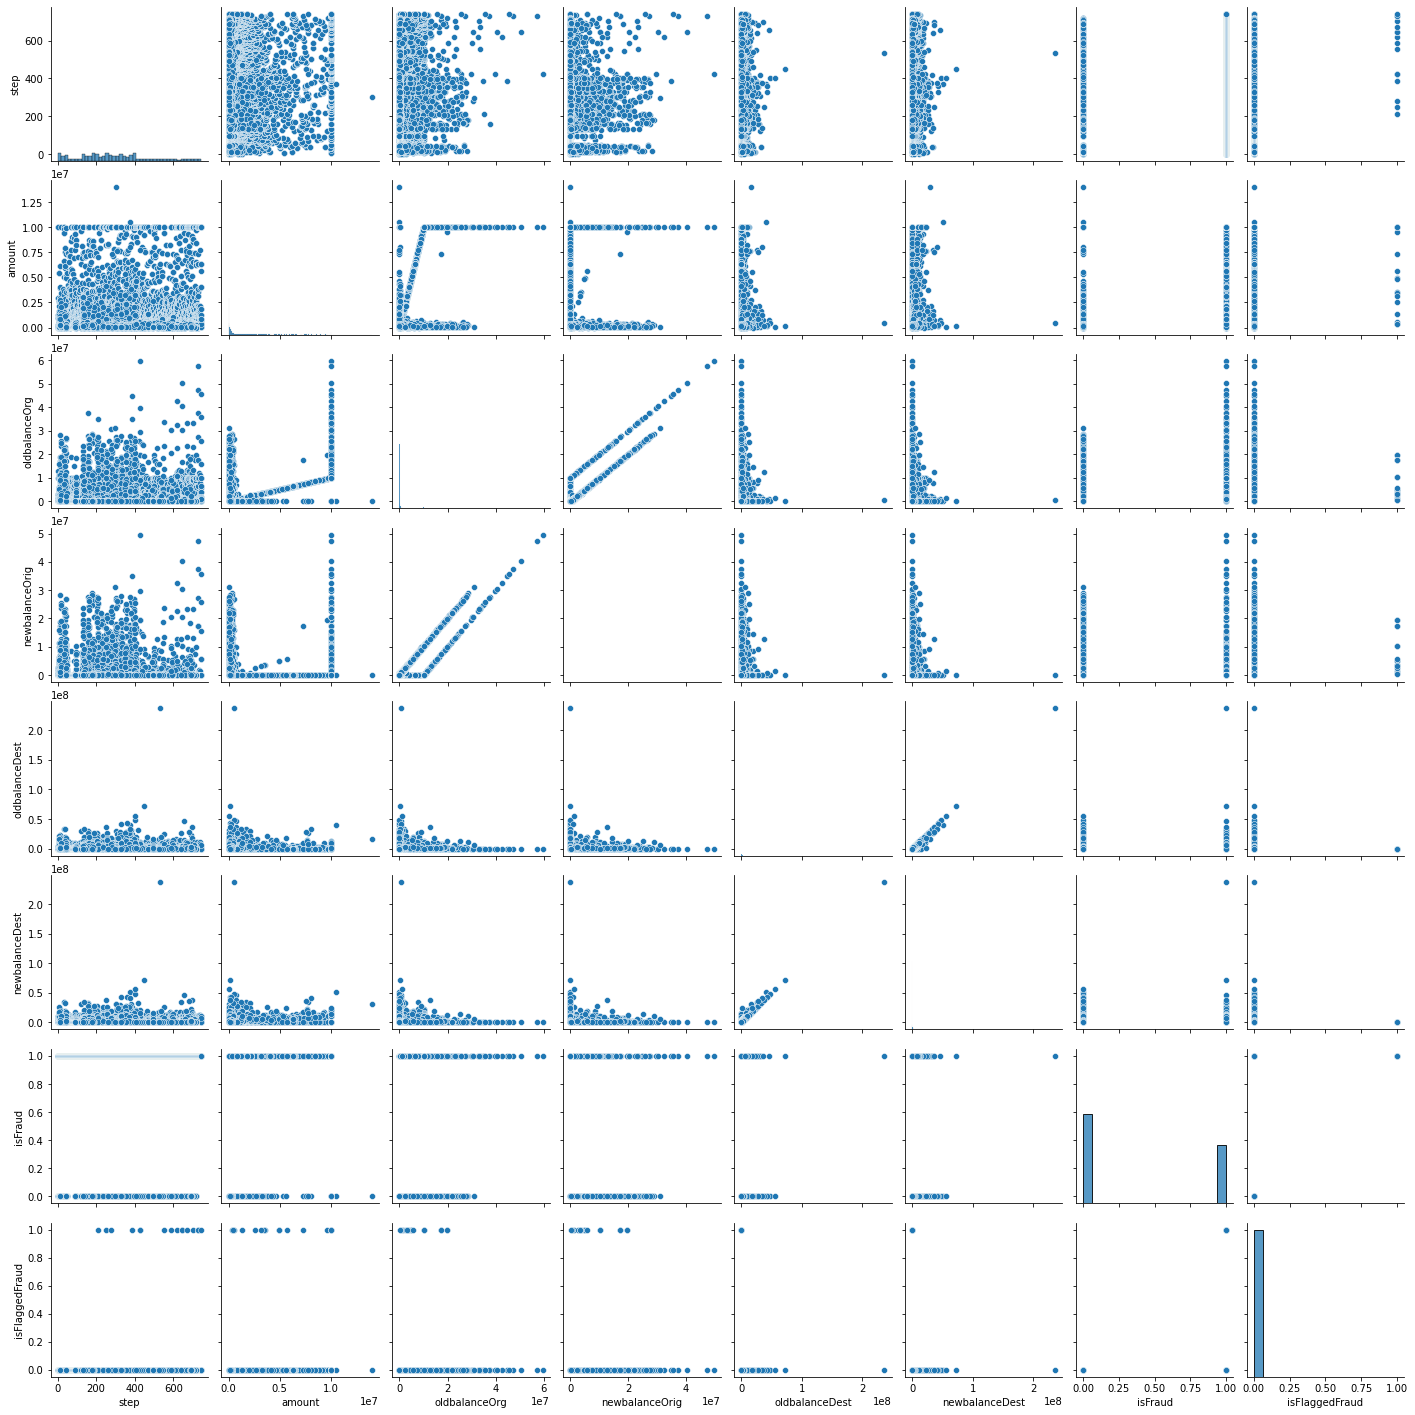

In [ ]:
sns.pairplot(resampled_data)

**Observations & Conclusions**
- From this plot we can spot that there existsa strong linear relationship between:
   - "oldbalanceOrig" and "newbalanceOrig"
   - "oldbalanceDest" and "newbalanceDest"
- Hence, we can use correlation matrix to spot correlation values to detect multicollinearity and perform appropriate transformations

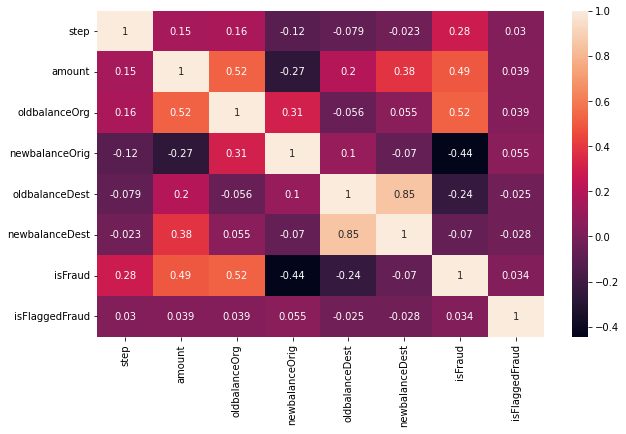

In [ ]:
corr=resampled_data.corr(method="spearman")
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)
plt.show()

**Observations & Conclusions**
- Deriving a new feature from the original features may help to fix this issue

In [ ]:
fraud_prop = (np.round((resampled_data[resampled_data["isFraud"]==1]["step"].value_counts() / len(resampled_data[resampled_data["isFraud"]==1]["step"].value_counts())), 2)).to_dict()
resampled_data["hourly_fraud_ratio"] = resampled_data["step"].apply(lambda x: fraud_prop[x] if x in fraud_prop.keys() else 0)
resampled_data_test["hourly_fraud_ratio"] = resampled_data_test["step"].apply(lambda x: fraud_prop[x] if x in fraud_prop.keys() else 0)

In [ ]:
# Checking how many attributes are dtype: object
objList = resampled_data.select_dtypes(include="object").columns
print (objList)

Index(['type'], dtype='object')


In [ ]:
# Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    resampled_data[feat] = le.fit_transform(resampled_data[feat].astype(str))
    resampled_data_test[feat] = le.fit_transform(resampled_data_test[feat].astype(str))
print (resampled_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18830 entries, 2 to 4876545
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   step                18830 non-null  int64  
 1   type                18830 non-null  int64  
 2   amount              18830 non-null  int64  
 3   oldbalanceOrg       18830 non-null  int64  
 4   newbalanceOrig      18830 non-null  int64  
 5   oldbalanceDest      18830 non-null  int64  
 6   newbalanceDest      18830 non-null  int64  
 7   isFraud             18830 non-null  int64  
 8   isFlaggedFraud      18830 non-null  int64  
 9   hourly_fraud_ratio  18830 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 1.6 MB
None


#### MULTICOLINEARITY

- Use Simple Correlation Test(s)
- Variance Inflation Factor (VIF)???

We can see that oldbalanceOrg and newbalanceOrig have too high VIF thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

Thus combine these pairs of collinear attributes and drop the individual ones.

In [ ]:
resampled_data["transaction_orig"] = resampled_data.apply(lambda x: x["oldbalanceOrg"] - x["newbalanceOrig"], axis=1)
resampled_data["transaction_dest"] = resampled_data.apply(lambda x: abs(x["oldbalanceDest"] - x["newbalanceDest"]), axis=1)
resampled_data = resampled_data.drop(["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"], axis=1)
resampled_data_test["transaction_orig"] = resampled_data_test.apply(lambda x: x["oldbalanceOrg"] - x["newbalanceOrig"], axis=1)
resampled_data_test["transaction_dest"] = resampled_data_test.apply(lambda x: abs(x["oldbalanceDest"] - x["newbalanceDest"]), axis=1)
resampled_data_test = resampled_data_test.drop(["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"], axis=1)

In [ ]:
resampled_data[["amount", "transaction_orig", "transaction_dest"]] = np.round(resampled_data[["amount", "transaction_orig", "transaction_dest"]], 0).astype("int64")
resampled_data_test[["amount", "transaction_orig", "transaction_dest"]] = np.round(resampled_data_test[["amount", "transaction_orig", "transaction_dest"]], 0).astype("int64")
resampled_data[resampled_data["isFraud"]==1]["transaction_orig"]

2              181
3              181
251           2806
252           2806
680          20128
            ...   
6362615     339682
6362616    6311409
6362617    6311409
6362618     850003
6362619     850003
Name: transaction_orig, Length: 7392, dtype: int64

In [ ]:
resampled_data[["amount", "transaction_orig", "transaction_des"]] = np.round(resampled_data[["amount", "transaction_orig", "transaction_dest"]], 0).astype("int64")
resampled_data_test[["amount", "transaction_orig", "transaction_des"]] = np.round(resampled_data_test[["amount", "transaction_orig", "transaction_dest"]], 0).astype("int64")

In [ ]:
resampled_data["amount"].value_counts()

10000000    256
0            15
125464        4
5271          4
1244          4
           ... 
127186        1
966965        1
67319         1
291416        1
160260        1
Name: amount, Length: 14848, dtype: int64

**Observations and Analysis**
1. Are fraudulent transactions concerned with a particular type of amount/cash transfer?
2. All fraudulent transactions have no balance change in the target account

In [ ]:
resampled_data["transaction_orig"], resampled_data["transaction_orig"] = abs(resampled_data["transaction_orig"]), abs(resampled_data["transaction_orig"])
resampled_data_test["transaction_orig"], resampled_data_test["transaction_orig"] = abs(resampled_data_test["transaction_orig"]), abs(resampled_data_test["transaction_orig"])
resampled_data, resampled_data_test = resampled_data.drop(["transaction_des", "step"], axis=1), resampled_data_test.drop(["transaction_des", "step"], axis=1)

## Model Development

### Metric Functions

**Random Stuff**
- Decision Tree
- Logistic Regression - outlier removal AND normality constraints
- SVM
- Random Forest AND ANN

Hyperparameter Tuning and Optimization
- Dataset Upsampling and Downsampling - Downsampling preferred - but recall may increase - reduce the size further AND give importance to the lower label
- Cross Validation (just perform on 2-3 best models)
    - Decision Tree
    - Random Forest
    - KNNs - ???
    - GBs: AdaBoost, XGBoost

In [ ]:
# Method for calculating model accuracy
def calculate_accuracy(test, predictions):
  target_names = ["Label0", "Label1"]
  acc_score = metrics.accuracy_score(test, predictions)
  cls_report = metrics.classification_report(test, predictions, target_names=target_names)
  return acc_score, cls_report

# Using RandomizedSearch CV for training with cross validation
def fine_tune_gsearch(classifier, parameters, X_train, y_train):
  rm = GridSearchCV(estimator=classifier, param_grid=parameters, n_jobs=-1, scoring="f1_weighted", cv=skFold)
  search = rm.fit(X_train, y_train)
  bs = search.best_score_
  bp = search.best_params_
  return bs, bp

def fine_tune_rsearch(classifier, parameters, X_train, y_train):
  rm = RandomizedSearchCV(estimator=classifier, param_distributions=parameters, n_jobs=-1, scoring="f1_weighted", cv=skFold, random_state=seed_value)
  search = rm.fit(X_train, y_train)
  bs = search.best_score_
  bp = search.best_params_
  return bs, bp

In [ ]:
# Initialise the cross validation
skFold = StratifiedKFold(shuffle=True, random_state=seed_value)

In [ ]:
Y = resampled_data["isFraud"]
Y_test = resampled_data_test["isFraud"]
X = resampled_data.drop(columns=["isFraud", "isFlaggedFraud"], axis=1)
X_test = resampled_data_test.drop(columns=["isFraud", "isFlaggedFraud"], axis=1)
(X_train, X_valid, Y_train, Y_valid) = train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=Y, random_state=seed_value)

In [ ]:
# Define Decision Tree Classifier
def decision_tree_model(*params, criterion, max_features):
    if criterion == None and max_features == None:
        dt = DecisionTreeClassifier(random_state=seed_value)
    else:
        dt = DecisionTreeClassifier(criterion=criterion, max_features=max_features, random_state=seed_value)
    dt.fit(params[0], params[2])
    Y_pred_dt = dt.predict(params[1])
    dt_accuracy_score, dt_report = calculate_accuracy(params[3], Y_pred_dt)
    return dt, dt_accuracy_score, dt_report

In [ ]:
# Pass parameters
model, accuracy_score, score_report = decision_tree_model(X_train, X_valid, Y_train, Y_valid, criterion=None, max_features=None)
preds_test = model.predict(X_test)
model_score, model_report = calculate_accuracy(Y_test, preds_test)

In [ ]:
print(f"Test Set Accuracy Score: {model_score:.2f}")
print(model_report)

Test Set Accuracy Score: 0.96
              precision    recall  f1-score   support

      Label0       0.96      0.97      0.97      1271
      Label1       0.96      0.94      0.95       821

    accuracy                           0.96      2092
   macro avg       0.96      0.96      0.96      2092
weighted avg       0.96      0.96      0.96      2092



**Observations and Analysis**
- By mere undersampling, we have managed to increase the precision and recall on the minority label, though at the expense of minor decrease in accuracy in the detection of legitimate transactions, which can be accepted upto some extent

In [ ]:
fraud = resampled_data[resampled_data["isFraud"]==1]
notfraud = resampled_data[resampled_data["isFraud"]==0]
fraud["type"].value_counts()

4    3701
1    3691
Name: type, dtype: int64

In [ ]:
fraud["transaction_orig"].value_counts()

10000000    253
0            52
1165188       4
537540        4
125464        4
           ... 
1767113       1
539088        1
2085020       1
140333        1
181           1
Name: transaction_orig, Length: 3894, dtype: int64

In [ ]:
notfraud["transaction_orig"].value_counts()

0         3742
124          6
164          5
160          5
158          4
          ... 
150          1
941          1
18456        1
164976       1
61195        1
Name: transaction_orig, Length: 7188, dtype: int64

In [ ]:
dt.feature_importances_

array([0.29775414, 0.08852285, 0.00659297, 0.45764834, 0.1494817 ])

- Source and Destination Account Types (Customer or Merchant Accounts) is not a good determinator for fraudulent attacks in this use-case. Moroever, such features are sparsely populated, and don't add any real value

In [ ]:
# Perform Predictions on Reduced Feature Space
X_train_sampled = X_train[["type", "transaction_orig", "transaction_dest"]]
X_valid_sampled = X_valid[["type", "transaction_orig", "transaction_dest"]]
X_test_sampled = X_test[["type", "transaction_orig", "transaction_dest"]]

In [ ]:
# Hyperparameter Tuning using Grid Search with Stratified K-Fold Cross Validation
dt = DecisionTreeClassifier(random_state=seed_value)
parameters_dt = {
                    "criterion": ["gini", "entropy"],
                    "max_features": ["auto", "sqrt", "log2"]
}
bs, bp = fine_tune_gsearch(dt, parameters_dt, X_train_sampled, Y_train)
print(f"Weighted F1-Score: {bs:.2f}")
print(bp) # Best set of hyperparameters

Weighted F1-Score: 0.95
{'criterion': 'entropy', 'max_features': 'auto'}


In [ ]:
# Re-Train Decision Tree Classifier using best hyperparameter subset
model, accuracy_score, score_report = decision_tree_model(X_train_sampled, X_valid_sampled, Y_train, Y_valid, criterion="entropy", max_features="auto")
print(score_report)

              precision    recall  f1-score   support

      Label0       0.96      0.97      0.96      3431
      Label1       0.95      0.94      0.94      2218

    accuracy                           0.96      5649
   macro avg       0.96      0.95      0.95      5649
weighted avg       0.96      0.96      0.96      5649



**Observations and Analysis**
- We don't observe any appreciable increase in accuracy or F1-score through hyperparameter tuning on the reduced feature set

#### Random Forest Classifier

In [ ]:
random_forest = RandomForestClassifier(random_state=seed_value, class_weight={0: 1, 1: 2})
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_valid)
random_forest_score = random_forest.score(X_valid, Y_valid) * 100
acc_score_rf, class_score_rf = calculate_accuracy(Y_valid, Y_pred_rf)

In [ ]:
print(class_score_rf)

              precision    recall  f1-score   support

      Label0       0.97      0.97      0.97      3431
      Label1       0.95      0.95      0.95      2218

    accuracy                           0.96      5649
   macro avg       0.96      0.96      0.96      5649
weighted avg       0.96      0.96      0.96      5649



In [ ]:
# Perform Hyperparameter Tuning on the Random Forest Classifier
parameters_rf = {
              "n_estimators" : [int(i) for i in np.linspace(0, 500, 10)],
              "criterion": ["gini", "entropy"],
              "bootstrap" : [True, False],
              "max_features" : ["auto", "sqrt", "log2"]
}
bs_rf, bp_rf = fine_tune_rsearch(random_forest, parameters_rf, X_train, Y_train)
print(f"Weighted F1-Score: {bs_rf:.2f}")

Weighted F1-Score: 0.96


In [ ]:
random_forest = RandomForestClassifier(n_estimators=333, max_features="sqrt", criterion="gini", bootstrap=True, class_weight={0: 1, 1: 2}, random_state=seed_value)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100
acc_score_rf, class_score_rf = calculate_accuracy(Y_test, Y_pred_rf)

In [ ]:
print(class_score_rf)

              precision    recall  f1-score   support

      Label0       0.97      0.97      0.97      1271
      Label1       0.95      0.95      0.95       821

    accuracy                           0.96      2092
   macro avg       0.96      0.96      0.96      2092
weighted avg       0.96      0.96      0.96      2092



**Observations and Analysis**
- No appreciable increase in accuracy or F1-score is observed through the use of Random Forest Classifier

## EVALUATION

In [ ]:
# Classifier Scores
print(f"Decision Tree Score: {accuracy_score:.2f}")
print(f"Random Forest Score: {acc_score_rf:.2f}")

Decision Tree Score: 0.96
Random Forest Score: 0.96


In [ ]:
# Confusion Matrix - DT
print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, preds_test).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

# key terms of Confusion Matrix - RF

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 772
False Positives: 35
True Negatives: 1236
False Negatives: 49
----------------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 777
False Positives: 38
True Negatives: 1233
False Negatives: 44


**Observations and Analysis**
- Decision Tree predicts true negatives better than Random Forest, which proves its robustness in cases of fraud detection

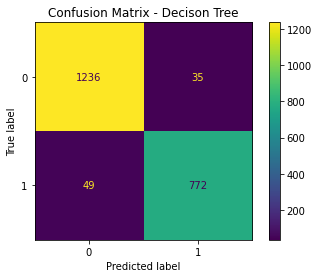

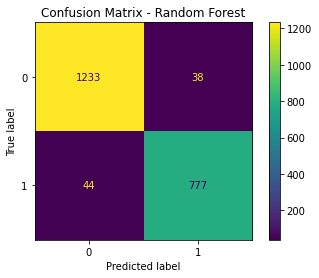

In [ ]:
# visualising confusion matrix for decision tree on test set
confusion_matrix_dt = metrics.confusion_matrix(Y_test, preds_test)
disp_dt = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp_dt.plot()
plt.title("Confusion Matrix - Decison Tree")
plt.show()

# visualising confusion matrix for random forest on test set
confusion_matrix_rf = metrics.confusion_matrix(Y_test, Y_pred_rf)
disp_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

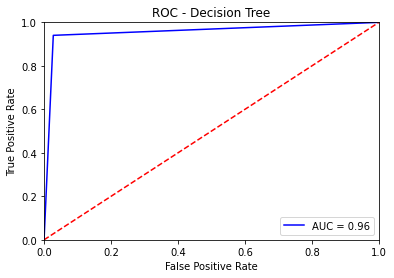

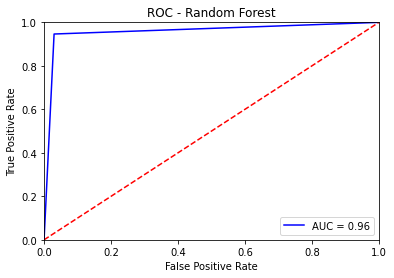

In [ ]:
# AUC ROC - Decision Tree
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds_test)
roc_auc = metrics.auc(fpr, tpr)
plt.title("ROC - Decision Tree")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)
plt.title("ROC - Random Forest")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

- TPR increases steeply initially, then witnesses a gradual increase with a greater increase in instances of false positive cases

## CONCLUSION

**Describe your fraud detection model**
   - Both of these algorithms are robust to outliers and possess the ability to capture edge-cases which increases the precision for the minrority label,which is of utmost importance in such a use-case. Moreover, both models are known for their feature interpretability, which is essential for fraud detection
   - Possesses the ability to capture data imbalance well by assigning class weights to labe;s. Due to this, the model can be penalized for the misclassification of higher weighted label.
   - Oher sophisicated algorithms such as Boosting or ANN can possibly enhance the precision for such models but it comes at the loss of interpretability, which is not always desirable in such cases. Moreover, they require robust outlier treatment which can lead to potential loss of crucial feature information
**How did you select variables to be included in the model?**
- I used correlation matrix for detection of multicollinearity. To remove redundancy, I transformed the feature space by performing
- After first model iteration, I used "feature_importances_" provided by decision tree to get an overview of which predictors contribute the most to the classification problem

**Key Factors predicting Fraudulent Customer**
- Type/Category of transaction
- Transaction in the source account
- Transaction in the destination account

**Do these factors make sense?If yes, then how? If no, then why not? Prevention and Feedback of Implemented Safety Measures**
- Most of the fraudulent activities are classified as "CASH_OUT" and "TRANSFER"
    - Cash-out fraud involves using stolen or counterfeit credit or debit card information to physically withdraw cash from the victim's account
        - The financial company can update its existing technical infrastructure to enable instantaneous blocking of stolen account information
        - It can deploy instant automated response systems to inform customers of any debit activity through messaging and email both. In this way, customers will be informed of any malicious debit activity through the usage of counterfeit cards
    - Transfer fraud is a type of fraud in which a fraudster tricks a victim into transferring money or assets to the fraudster's account or a third-party account. Such frauds can take forms including email scams, phone scams OR social engineering attacks
        - The institution can implement controls which require multiple approvals for large transfers and conducting regular audits of any financial transaction
        - It must inform its customers to not share sensitive account information to anyone, not even the company officials themselves. Moreover, account holders must be adequately told to be wary of any unsolicited requests for payments and transfer of funds
        
- "CASH_IN" refers to account cash deposit, which is not normally a case of fraudulent activity. Moreover, it can be observed that not a single duplicit  transaction has been caused due to this type of fund transfer. Hence, the type of fund transfer becomes an important parameter in the detection of account frauds

- We can also observe that large fund transfers from source accounts is by far the most important determinator of fraudulent activities
    - The financial institution must immediately can contact the customer and gather information WRT large account transfers
    - It can implement KYC for account holder verification and determine if such transfers were legitimate

- Other preventions while the company updates its infrastructure
    - Usage of user-secured mobile banking apps for large fund transfers
    - Usage of Incognito mode to avoid cookie storage